파이토치의 **nn module**을 사용하여 신경망을 구현하기에 앞서, 이해를 위해 기본 파이토치 연산만을 이용하여 **Linear Regression Model**을 구현해보자

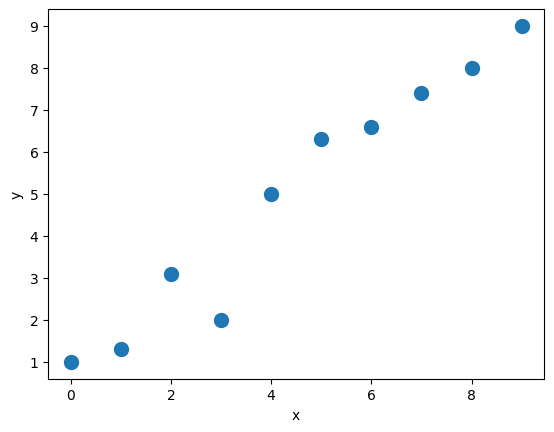

In [16]:
import numpy as np
import matplotlib.pyplot as plt

X_train = np.arange(10, dtype = 'float32').reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0], dtype='float32')

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

이후, 데이터셋을 **표준화**하고, **Batch** 별로 나누기 위해 **DataLoader**를 사용해보자

**TensorDataset**은 **Tensor만을 입력으로 사용하는** Dataset의 Sub-class로 비교적 간단한 Dataset을 정의할 때 사용된다.

In [17]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Standardization
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm, y_train)

batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

이제 $z = wx + b$로 **Linear Regression model**을 정의한다.

직접 **Linear Regression Model**을 정의하고, 모델의 Parameter로 **Weight, Bias**를 정의한다.

**Loss function**으로는 **MSE**를 사용한다.

In [18]:
torch.manual_seed(1)

weight = torch.randn(1)
weight.requires_grad_()

bias = torch.zeros(1, requires_grad=True)

def model(xb):
    return xb @ weight + bias

def loss_fn(input, target):
    return (input - target).pow(2).mean()

**Optimization** 방법으로는 **SGD**를 사용한다.

지금은 직접 구현하지만, **Gradient**를 계산하는 부분은 파이토치의 **torch.autograd.backward** 함수를 사용한다.

**Epoch = 200**으로 설정하고, 모델을 훈련하는 코드는 아래와 같다.

In [19]:
learning_rate = 0.001
num_epochs = 200
log_epochs = 10

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()

    with torch.no_grad():
        weight -= weight.grad * learning_rate
        bias -= bias.grad * learning_rate

        # Update 후 반드시 Gradient를 0으로 초기화해야 한다.
        weight.grad.zero_()
        bias.grad.zero_()

    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}, Loss {loss.item():.4f}')

Epoch 0, Loss 41.2725
Epoch 10, Loss 24.4285
Epoch 20, Loss 1.0575
Epoch 30, Loss 15.1630
Epoch 40, Loss 12.5989
Epoch 50, Loss 5.0840
Epoch 60, Loss 0.7865
Epoch 70, Loss 3.7489
Epoch 80, Loss 2.4036
Epoch 90, Loss 0.4430
Epoch 100, Loss 1.1155
Epoch 110, Loss 1.3195
Epoch 120, Loss 0.1064
Epoch 130, Loss 0.5676
Epoch 140, Loss 0.2216
Epoch 150, Loss 1.4862
Epoch 160, Loss 0.0483
Epoch 170, Loss 0.0061
Epoch 180, Loss 0.0016
Epoch 190, Loss 0.0294


위에서 훈련한 모델을 그래프로 시각화해보자.

**Test data**는 0 ~ 9까지의 일정한 간격을 가진 Numpy data를 사용한다.

중요한 점은 **Training data에 표준화를 적용했기 때문에, Test data에서 표준화를 적용해야 한다는 점이다.**

최종 파라미터: 2.645277738571167 4.715577602386475


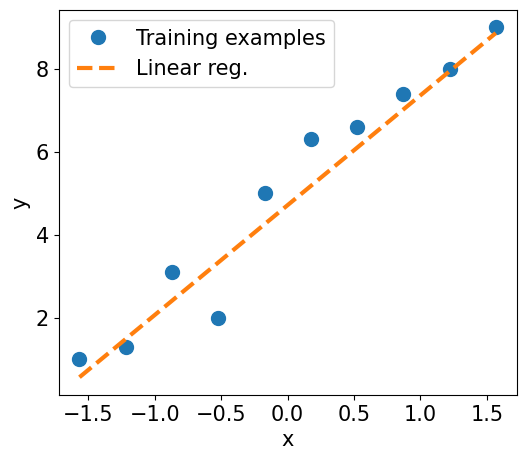

In [20]:
print('최종 파라미터:', weight.item(), bias.item())

X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)

# detach()는 autograd의 추적을 그만두게 한다.
y_pred = model(X_test_norm).detach()

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)

plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)

ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

방금 구현한 모델을 파이토치의 **torch.nn, torch.optim module**을 이용하여 간단하게 구현할 수 있다.

In [21]:
import torch.nn as nn

loss_fn = nn.MSELoss(reduction='mean')
input_size = 1
output_size = 1

model = nn.Linear(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

이전 모델처럼 직접 **Linear layer**를 구현하는 대신, **torch.nn.Linear class**를 이용할 수 있다.

In [22]:
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. 예측 생성
        pred = model(x_batch)[:, 0] # [1, 1] shape tensor를 반환
        # 2. Loss 계산
        loss = loss_fn(pred, y_batch)
        # 3. Gradient 계산
        loss.backward()
        # 4. Parameter Update
        optimizer.step()
        # 5. Gradient를 0으로 초기화
        optimizer.zero_grad()

    if epoch % log_epochs == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

Epoch: 0, Loss: 24.6684
Epoch: 10, Loss: 29.1377
Epoch: 20, Loss: 20.9207
Epoch: 30, Loss: 0.1257
Epoch: 40, Loss: 12.4922
Epoch: 50, Loss: 1.7845
Epoch: 60, Loss: 7.6425
Epoch: 70, Loss: 2.5606
Epoch: 80, Loss: 0.0157
Epoch: 90, Loss: 0.7548
Epoch: 100, Loss: 0.8412
Epoch: 110, Loss: 0.4923
Epoch: 120, Loss: 0.0823
Epoch: 130, Loss: 0.0794
Epoch: 140, Loss: 0.0891
Epoch: 150, Loss: 0.0973
Epoch: 160, Loss: 0.1043
Epoch: 170, Loss: 0.1103
Epoch: 180, Loss: 0.0009
Epoch: 190, Loss: 0.0764


이전에 직접 구현한 모델과 결과가 비슷한지 확인해보자

In [23]:
print('최종 파라미터:', model.weight.item(), model.bias.item())

최종 파라미터: 2.6496422290802 4.87706995010376


이제 파이토치의 모듈을 이용하여 실제 데이터셋을 분류하는 방법에 대해 알아보자

데이터셋은 **sklearn의 붓꽃 데이터셋**을 사용한다.

먼저 **sklearn**에서 데이터셋을 가져오자

In [24]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

데이터셋을 표준화하고, Training set을 위한 파이토치 **Dataset과 DataLoader**를 만든다.

In [25]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()

y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

이제 **torch.nn module**을 상속받은 **Sub class**를 정의하여 모델을 구현할 수 있다.

각 Layer는 **MLP, FC Layer를** 사용하고, **Hidden Layer**의 크기는 16이다.

In [26]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Linear의 Parameter는 해당 Layer의 parameter size이다.
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Linear Class 내부에 __call()__ 함수가 구현되어 있어 아래와 같이 사용 가능
        # __call()__: 객체를 함수처럼 사용 가능하게 만드는 함수
        x = self.layer1(x)
        # nn.Sigmoid()로 객체를 만들고 __call()__ 함수를 바로 호출한 것
        x = nn.Sigmoid()(x)
        x = self.layer2(x)

        return x

input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size, hidden_size, output_size)

**Optimizer**는 **Adam**을 사용하고, **Loss function**은 **Cross Entropy Loss**를 사용한다.

In [27]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Epoch = 100**으로 설정하여 모델을 훈련시키자

In [28]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        
        loss = loss_fn(pred, y_batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item() * y_batch.size(0)

        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

**loss_hist와 accuracy_hist**를 이용하여 그래프로 시각화 해보자

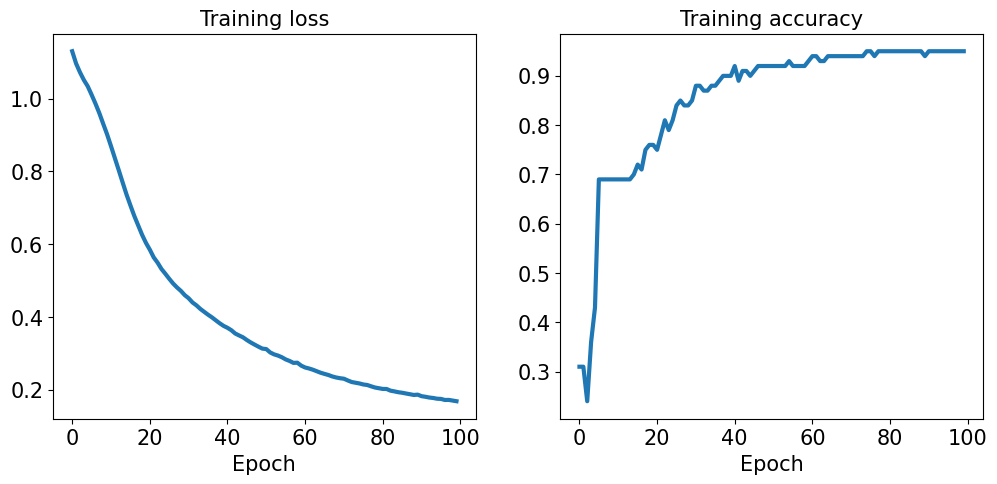

In [29]:
fig = plt.figure(figsize = (12, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size = 15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()


이제 **Test dataset**을 이용하여 모델을 평가할 수 있다.

In [30]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()

y_test = torch.from_numpy(y_test)

pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Accuracy: {100 * accuracy:.4f}%')

Test Accuracy: 98.0000%


여러 **Epoch** 중 **가장 결과값이 좋은 Model**을 저장할 필요가 있다.

나중을 위해 훈련된 모델을 디스크에 저장할 수 있다.

**.pt 확장자**는 PyTorch에서 모델이나 텐서를 저장할 때 사용하는 파일 형식이다.

In [34]:
path = 'iris_classifier.pt'
# 가장 좋은 모델을 path에 저장
torch.save(model, path) 

**load()를** 통해 저장한 모델을 불러올 수 있다

**load() 함수는** **weights_only=True**가 기본값으로, 모델을 불러올 때 Model의 **Parameter 정보만을 불러온다.**

저장과는 관련없지만, **model.eval()을** 통해 모델의 정보를 확인할 수 있다.

In [36]:
model_new = torch.load(path, weights_only=False)
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

저장하고 로드한 모델으로 Test Dataset을 다시 돌려보았을 때, 이전과 같은 결과가 나오는지 확인해 보자.

In [40]:
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()

accuracy = correct.mean()
print(f'Test accuracy: {100 * accuracy:.4f}')

Test accuracy: 98.0000


**torch.save()는** 모델 전체를 저장한다. 

만약 Model의 Parameter만 저장하고 싶다면 **torch.save(model.state_dict(), path)를** 사용한다.

Parameter만 저장한 모델을 불러올 때는 **weights_only=True**인 **model.load()** 함수를 사용할 수 있다.